## Req 1-1

이미지 파일 경로 받아서 출력. 사이즈가 다를 경우 동일화

In [3]:
import os

os.chdir('..')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm

In [3]:
#데이터셋 인덱스 불러오기
results = pd.read_csv('datasets/images/results.csv', sep="|")
result_index = results.image_name.unique()

In [ ]:
#전체 이미지 x,y 크기 분포 확인
x_list = []
y_list = []

#평균 250it/sec 
for index in tqdm(result_index) :
    path = 'datasets/images/'+index
    x_list.append(mpimg.imread(path).shape[0])
    y_list.append(mpimg.imread(path).shape[1])

In [37]:
# 500,500이 최대이므로 사이즈는 500,500으로 통일
max(x_list), max(y_list)

(500, 500)

In [2]:
#함수 구현
from PIL import Image, ImageOps
import numpy as np

def get_image(path) :
    desired_size = 500
    im = Image.open(path)
    old_size = im.size
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    im = im.resize(new_size, Image.ANTIALIAS)
    
    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
    
    #PIL to Array
    new_im_array = np.array(new_im)
    return new_im_array
    

In [3]:
get_image('datasets/images/65567.jpg').shape

(500, 500, 3)

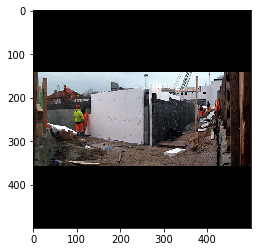

In [7]:
plt.imshow(get_image('datasets/images/8237901726.jpg'))

In [19]:
%%time
#이미지 각 낱장들을 합쳐 train datasets으로 변환
# 리스트로 append하면 매우매우 느림 (50it/sec 이하)
# 심지어 다 불러왔을 때 ram 22.2GB임 ㅋㅋㅋ
# 따라서 100개정도만 샘플로 해보자
image_list = []
for index in tqdm(result_index[:100]) :
    path = 'datasets/images/'+index
    image_list.append(get_image(path))
    
x_train = np.array(image_list)


Wall time: 290 ms


In [ ]:
%%time
#np append로 할 경우 훨씬 느림 ㅜㅜ 3it/sec
for index in tqdm(result_index) :
    path = 'datasets/images/'+index
    x_train2 = np.append(x_train2,get_image(path))

x_train2.reshape(31783,500,500,3)
    

## Req 1-2

이미지 RGB 정규화

In [ ]:
#전체 이미지 RGB값 리스트 획득
r_list = []
g_list = []
b_list = []

#list append = 500it/sec
#list extend - 50it/sec
for index in tqdm(result_index) :
    path = 'datasets/images/'+index
    image = mpimg.imread(path)
    r_list.append(image[:,:,0])
    g_list.append(image[:,:,1])
    b_list.append(image[:,:,2])

In [5]:
#전체 이미지 RGB dict 생성
r_dict = {}
g_dict = {}
b_dict = {}

#dict = 50it/sec
for index in tqdm(result_index) :
    path = 'datasets/images/'+index
    image = mpimg.imread(path)
    r_dict[index] = image[:,:,0]
    g_dict[index] = image[:,:,1]
    b_dict[index] = image[:,:,2]

In [71]:
%%time

#색상별 평균 작성
def calc_color_mean(color) :
    total_sum = 0
    total_num = 0
    
    if color == "r" :
        for key in r_dict :
            total_sum += r_dict[key].sum()
            total_num += r_dict[key].shape[0]*r_dict[key].shape[1]
    elif color == "g" :
        for key in g_dict :
            total_sum += g_dict[key].sum()
            total_num += g_dict[key].shape[0]*g_dict[key].shape[1]
    elif color == "b" : 
        for key in b_dict :
            total_sum += b_dict[key].sum()
            total_num += b_dict[key].shape[0]*b_dict[key].shape[1]
    else : 
        raise("색상을 입력해주세요")
    
    total_mean = total_sum/total_num
    return total_mean, total_num

Wall time: 0 ns


In [72]:
%%time
#R,G,B 평균
calc_color_mean("r"),calc_color_mean("g"),calc_color_mean("b")

Wall time: 14.1 s


((113.29718549490755, 5640430370),
 (107.4292929175899, 5640430370),
 (98.1446513821604, 5640430370))

In [86]:
%%time
#색상별 표준편차 계산
def calc_color_std(color,color_mean,color_num) :
    total_mean = color_mean
    total_num = color_num
    
    total_variance = 0
    if color == "r" :
        for key in r_dict :
            total_variance += ((r_dict[key] - total_mean)**2).sum()
    elif color == "g" :
        for key in g_dict :
            total_variance += ((g_dict[key] - total_mean)**2).sum()
    elif color == "b" : 
        for key in b_dict :
            total_variance += ((b_dict[key] - total_mean)**2).sum()
    else : 
        raise("색상을 입력해주세요")
    
    total_std = total_variance/total_num
    total_std = total_std ** 0.5
    return total_std

Wall time: 0 ns


In [87]:
%%time
calc_color_std("r",113.29718549490755, 5640430370)

Wall time: 35.1 s


72.70319221304833

In [88]:
%%time
calc_color_std("g",107.4292929175899, 5640430370)

Wall time: 34.3 s


70.71531997497007

In [89]:
%%time
calc_color_std("b",98.1446513821604, 5640430370)

Wall time: 34.5 s


72.88658387246883

In [ ]:
#R :(113.29718549490755, 72.70319221304833),
#G :(107.4292929175899, 70.71531997497007),
#B :(98.1446513821604, 72.88658387246883)

In [ ]:
#전체 이미지 Standirdize
def normalize_image(image,mean,stddev) :
    return (image - mean)/stddev

## Req 3-1

tf.data.Dataset으로 불러오기

In [92]:
import tensorflow as tf

#이미지 Array를 Dataset으로 변환
data = tf.data.Dataset.from_tensor_slices(get_image('datasets/images/8237901726.jpg'))

#텍스트 string을 Dataset으로 변환
#RNN쪽에서 Tokenize 해줘야 함

In [99]:
def create_dataset(path) :
    image = tf.data.Dataset.from_tensor_slices(get_image(path))
    
    return image

In [111]:
data = create_dataset(x_train)

## Req 3-2

#### 데이터 Augmentation 적용
keras.preprocessing.image.ImageDataGenerator(datagen)를 사용하면, 데이터를 realtime으로 augmentation 해줌

https://keras.io/preprocessing/image/

In [20]:
x_train.shape

(100, 500, 500, 3)

In [29]:
from keras.preprocessing.image import ImageDataGenerator

#테스트용으로 cifar10 이미지셋 사용
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Augmentation 설정을 저장한 datagen 객체 선언
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

#원하는 datasets를 datagen에 적용
#(주의! data를 rank4로 맞춰줘야 함)
datagen.fit(x_train)

#fit_generator 메소드를 통해 iteration하면서 fitting
# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=epochs)

170500096/170498071 [==============================] - 870s 5us/step


NameError: name 'epochs' is not defined

## Req 4-1

Encoder model 작성

https://www.kaggle.com/ramezashendy/cifar-10-pretrained-resnet

In [1]:
from keras.applications import resnet50
from keras.preprocessing import image

Using TensorFlow backend.


In [5]:
# 테스트용으로 사용할 모델 - Keras Pretrained ResNet 50
RESNET50_WEIGHTS = 'Requirement/saved_models/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
RESNET50_NOTOP_WEIGHTS = 'Requirement/saved_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = resnet50.ResNet50(weights=RESNET50_WEIGHTS)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [6]:
#모델의 사이즈인 224,224에 맞게 변경
img = image.load_img("Requirement/Kuszma.JPG", target_size=(224, 224))

#PIL 이미지를 numpy array로 변경
x = image.img_to_array(img)

# Add a forth dimension since Keras expects a list of images
x = np.expand_dims(x, axis=0)

In [7]:
# Scale the input image to the range used in the trained network
x = resnet50.preprocess_input(x)

In [11]:
# Run the image through the deep neural network to make a prediction
predictions = model.predict(x)

UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1/convolution}}]]
	 [[fc1000/Softmax/_1925]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1/convolution}}]]
0 successful operations.
0 derived errors ignored.

In [8]:
#model의 output layer가 fc1000이므로, feature 1000개가 추출되어 나온다
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

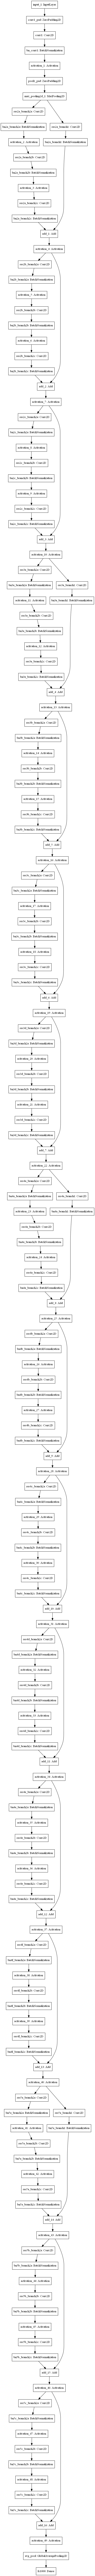

In [9]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [15]:
predictions.shape

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

NameError: name 'predictions' is not defined

In [60]:
# Look up the names of the predicted classes. Index zero is the results for the first image.
predicted_classes = resnet50.decode_predictions(predictions, top=9)

for imagenet_id, name, likelihood in predicted_classes[0]:
    print(" - {}: {:2f} likelihood".format(name, likelihood))

 - Border_terrier: 0.363326 likelihood
 - German_shepherd: 0.166199 likelihood
 - malinois: 0.128088 likelihood
 - Rottweiler: 0.073926 likelihood
 - Airedale: 0.040235 likelihood
 - Doberman: 0.035304 likelihood
 - bluetick: 0.016138 likelihood
 - American_Staffordshire_terrier: 0.015322 likelihood
 - kelpie: 0.014207 likelihood


In [64]:
#Transfer learning을 통해 우리가 원하는 대로 output layer 변경

pretrained_model = resnet50.ResNet50(weights=RESNET50_WEIGHTS)

#기존 layer freeze
for layer in pretrained_model.layers[0:-21]:
    layer.trainable = False

In [ ]:
from keras.layers import ZeroPadding2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [ ]:
#우리가 원하는 레이어 구조로 변경
model.add(ZeroPadding2D((96, 96), input_shape=(32, 32,  3)))
model.add(pretrained_model)
#model.add(k.layers.Flatten())
#model.add(k.layers.GlobalAveragePooling2D())
#model.add(k.layers.Dense(1024, activation='relu'))
model.add(k.layers.Dense(num_class, activation='softmax'))

## Req 4-2
Feature Encoder 작성

In [ ]:
#단순 크기, 차원만 변경하면 됨

## Req 6-1
Loss Func

In [ ]:
# 이거는 근데 RNN과 CNN을 동시에 고려해야 되므로 빡셈

## Req 6-2
One-Batch train step 함수

In [ ]:
# 이것도 RNN 동시 고려

## Req 8-1
체크포인트